In [153]:
import sys; sys.path.append('..')
import random
import pyzx as zx
from sympy import Matrix
from fractions import Fraction
%config InlineBackend.figure_format = 'svg'

In [18]:
def t_count(g): return len([v for v in g.vertices() if g.get_angle(v).denominator == 4])

In [122]:
random.seed(200)
q = 5
d = 15
t = 3
circ = zx.examples.cliffords(q, d)
for i in range(0,t):
    circ.add_angle(random.randint(q,len(circ.vertices())-q-1), Fraction(1/4))

In [72]:
t_count(circ)

3

In [123]:
zx.clifford_simp(circ)

spider_simp
9. 3. 1. 
finished in 4 iterations
pivot_simp
5. 1. 
finished in 3 iterations
lcomp_simp
5. 2. 1. 
finished in 4 iterations
pivot_simp

finished in 1 iterations


In [74]:
t_count(circ)

3

In [50]:
1 - (149/179)

0.16759776536312854

In [128]:
circ.is_connected(9, 42)

True

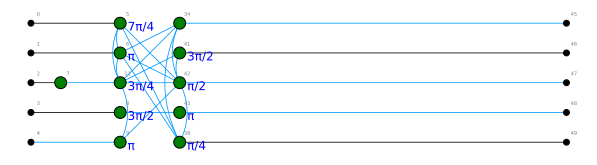

In [135]:
circ.set_vdata(5, 'r', 3)
circ.set_vdata(34, 'r', 5)
circ.set_vdata(6, 'r', 3)
circ.set_vdata(41, 'r', 5)
circ.set_vdata(11, 'r', 3)
circ.set_vdata(42, 'r', 5)
circ.set_vdata(43, 'r', 3)
circ.set_vdata(38, 'r', 3)
circ.set_vdata(9, 'r', 3)
circ.set_vdata(38, 'r', 5)
circ.set_vdata(8, 'r', 3)
circ.set_vdata(43, 'r', 5)
zx.draw(circ, labels=True)

In [81]:
circ.is_connected(7, 42)

False

In [112]:
random.seed(201)
q = 3
d = 20
t = 3
circ1 = zx.examples.cliffords(q, d)
for i in range(0,t):
    circ1.add_angle(random.randint(q,len(circ1.vertices())-q-1), Fraction(1/4))

In [113]:
zx.clifford_simp(circ1)
zx.drawing.pack_circuit_ranks(circ1)

spider_simp
9. 6. 3. 1. 
finished in 5 iterations
pivot_simp
4. 1. 1. 
finished in 4 iterations
lcomp_simp
5. 2. 
finished in 3 iterations
pivot_simp
1. 
finished in 2 iterations


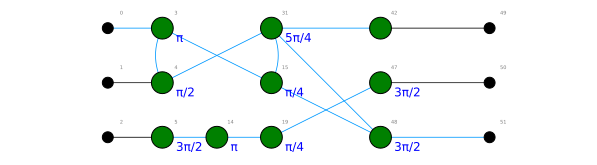

In [114]:
circ1.set_vdata(31, 'r', 3)
circ1.set_vdata(15, 'r', 3)
circ1.set_vdata(47, 'r', 5)
circ1.set_vdata(48, 'r', 5)
zx.draw(circ1, labels=True)

In [143]:
random.seed(201)
q = 3
d = 50
tprob = 0.05
circ2 = zx.examples.cliffords(q, d)
for i in range(q,circ2.num_vertices() - q):
    if tprob > random.random():
        circ2.add_angle(i, Fraction(1/4))

In [144]:
t_count(circ2)

10

In [146]:
print(t_count(circ2))
zx.clifford_simp(circ2)
zx.drawing.pack_circuit_ranks(circ2)
print(t_count(circ2))

10
spider_simp

finished in 1 iterations
pivot_simp

finished in 1 iterations
lcomp_simp

finished in 1 iterations
pivot_simp

finished in 1 iterations
10


In [192]:
after(circ2, [3,22,26])

[29, 34, 65, 88, 96, 106]

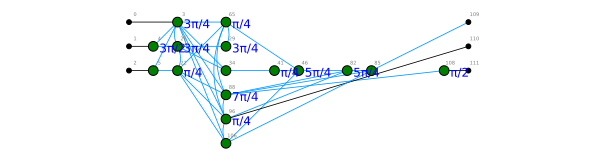

In [195]:
circ2.set_vdata(3, 'r', 2)
circ2.set_vdata(26, 'r', 2)
circ2.set_vdata(65, 'r',  4)
circ2.set_vdata(29, 'r',  4)
circ2.set_vdata(34, 'r',  4)
circ2.set_vdata(88, 'r',  4)
circ2.set_vdata(96, 'r',  4)
circ2.set_vdata(106, 'r', 4)
circ2.set_vdata(88, 'q', 3) #2
circ2.set_vdata(96, 'q', 4) #1
circ2.set_vdata(106, 'q',5) #0
zx.draw(circ2, labels=True)

In [162]:
def after(g, vs):
    rank = max(g.get_vdata(v, 'r') for v in vs)
    return [w for w in g.vertices() if g.get_vdata(w, 'r') > rank and any(g.is_connected(v, w) for v in vs)]
def bi_adj(g, vs, ws):
    return Matrix([[1 if g.is_connected(v,w) else 0 for v in vs] for w in ws])
def fwd_adj(g, vs):
    return bi_adj(g, vs, after(g,vs))

In [168]:
circ2.is_connected(22, 88)

True

In [158]:
after(circ2, [3, 26, 22])
#bi_adj([3, 26, 22], [])

[29, 34, 65, 88, 96, 106]

In [177]:
m = fwd_adj(circ2, [3,26,22])
m

Matrix([
[0, 1, 0],
[1, 1, 0],
[1, 0, 1],
[1, 0, 1],
[1, 0, 1],
[1, 0, 1]])

In [188]:
m.T.rank()

3

In [183]:
n = Matrix([[1,0,0],[0,1,0],[-1,0,1]])
k = m * n
k

Matrix([
[0, 1, 0],
[1, 1, 0],
[0, 0, 1],
[0, 0, 1],
[0, 0, 1],
[0, 0, 1]])

In [185]:
n.inv()

Matrix([
[1, 0, 0],
[0, 1, 0],
[1, 0, 1]])

In [184]:
k * n.inv()

Matrix([
[0, 1, 0],
[1, 1, 0],
[1, 0, 1],
[1, 0, 1],
[1, 0, 1],
[1, 0, 1]])

**The idea:**

Working with a circuit of N qubits.

Take the bi-adjacency matrix of the active rank with all of its successors. This is a matrix with N columns and N+k rows. Apply CNOTs until we are in column-reduced echelon form. If any qubit has all zeros in rows > N, replace it with its unique successor. Continue until all nodes are consumed.